# Mask Maker

## An attempt to try to make a mask that'll tell us where lakes and land are.

### This'll be... fun.

So, we have several masks of Titan that have been taken vrom various VIMS flybys. The problem is these masks don't line up and there's a lot of potential errors in where everything is. So, we're going to carefully try to stitch it all toegther to find out which areas are definitely land, which are definitely sea, and which are "no go" zones near the shoreline. To do that, we need to be able to read the images.

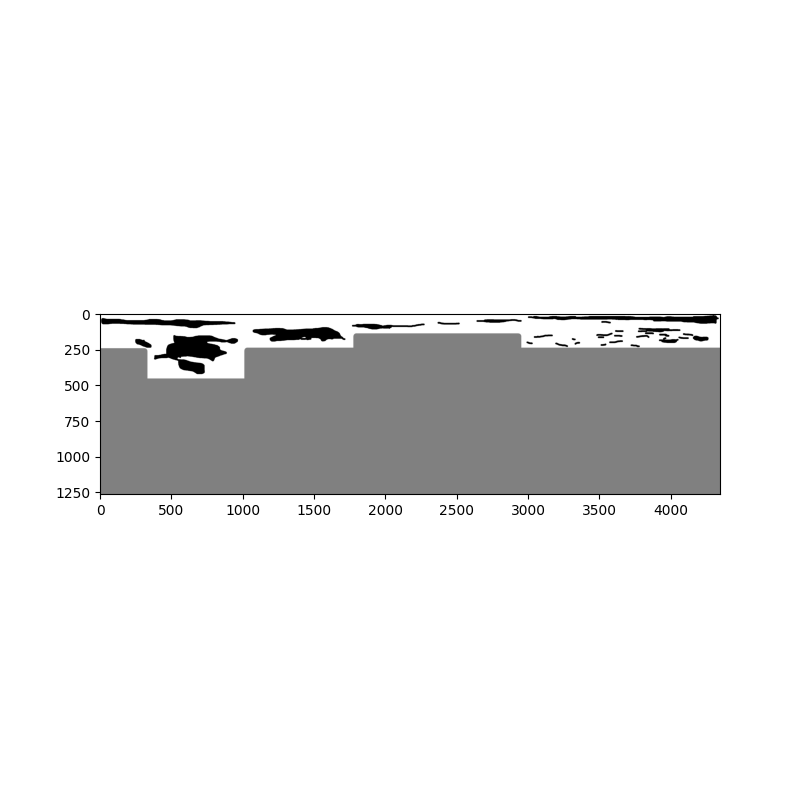

In [36]:
# READ IN FILES

#IMPORTS 
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# READ IN METADATA FILE
metadata = [[0 for x in range(8)] for x in range(11)] 
#There are 11 flybys and 8 values we keep track of for each one.
#Flyby Num, Up, Down, Left, Right, X Pixel Dimension, Y Pixel Dimension, Resolution
#Up/down/left/right refers to the direction the value was measured from. In theory
#these are related to latlon extremes. In practice they are something else and
#will have to be converted. 

with open('DimensionsLatLon.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i,j = 0,0
    for row in csv_reader:
        if (i == 0):
            i=i+1
        else: 
            j=0
            while (j < 8):
                metadata[i-1][j] = int(row[j])
                j=j+1
            i=i+1

#Now we need to read in the images so we can manipulate them.
im1 = Image.open("T67.Egress.lanczos.seqreplace.cyl.Jcube69.tif")
ima1 = np.array(im1)
im2 = Image.open("T76.Egress.lanczos.seqreplace.cyl.Jcube69.tif")
ima2 = np.array(im2)
im3 = Image.open("T93.Ingress.lanczos.seqreplace.cyl.Jcube69.tif")
ima3 = np.array(im3)
im4 = Image.open("T94.Ingress.lanczos.seqreplace.cyl.Jcube69.tif")
ima4 = np.array(im4)
im5 = Image.open("T96.Ingress.lanczos.seqreplace.cyl.Jcube69.tif")
ima5 = np.array(im5)
im6 = Image.open("T97.Ingress.lanczos.seqreplace.cyl.Jcube69.2.tif")
ima6 = np.array(im6)
im7 = Image.open("T98.Ingress.lanczos.seqreplace.cyl.Jcube69.tif")
ima7 = np.array(im7)
im8 = Image.open("T100.Ingress.lanczos.seqreplace.cyl.Jcube69.tif")
ima8 = np.array(im8)
im9 = Image.open("T104.Egress.nn.seqreplace.cyl.Jcube69.tif")
ima9 = np.array(im9)

allImages = [ima1, ima2, ima3, ima4, ima5, ima6, ima7, ima8, ima9]

fig, ax = plt.subplots(figsize = (8,8))
image = ax.imshow(ima3)
#Tifs are stored by y, x, and then RGB. RGB is mostly irrelevant to us though, as this is monochrome. 

We now have everything stored in the "allImages" array. Problem is that everything is at its own resolution, we need to be able to compare them to each other. The highest resolution we are using is 12, that is, every lat-lon pixel is divided into 12. Flybys 67 76 and 93 have these resolutions, so they don't need to be changed. The rest, however, definitely do. Unfortunately it's not just as simple as duplicating pixels by an exact scale, as we have an odd number of pixels in each set. Usually we range from -180 to 180, but that includes a 0 pixel, so the divisions get a little messy. We don't want to interpolate as our values are only 0 and 1, we want to find the nearest neighbor. 

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8


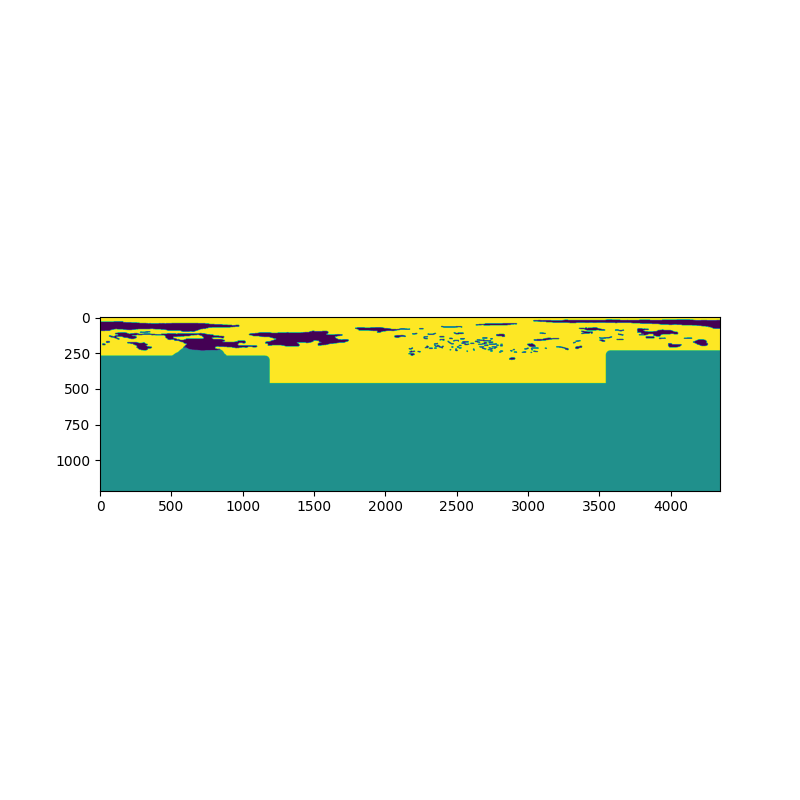

In [37]:
# UPSCALE THE IMAGES
#basically replace the old images with their new ones.
#The hope is that I can make use of the pointers being a reference instead of fighting against it this time.
#This takes a long time. But it only has to be run once, so yay!

#Have to make the new grids outside the loop so they aren't overridden or lost.
#(There is more defintiely a better way to do this, I just don't know what it is).
#The first three are the right size but we want to convert them to true monocrhome arrays.
grid1 = [[0 for x in range(int(((metadata[0][5]-1)/(metadata[0][7]))*12)+1)] 
         for x in range(int((((metadata[0][6]-1)/(metadata[0][7]))*12)+1))] 
grid2 = [[0 for x in range(int(((metadata[1][5]-1)/(metadata[1][7]))*12)+1)] 
         for x in range(int((((metadata[1][6]-1)/(metadata[1][7]))*12)+1))] 
grid3 = [[0 for x in range(int(((metadata[2][5]-1)/(metadata[2][7]))*12)+1)] 
         for x in range(int((((metadata[2][6]-1)/(metadata[2][7]))*12)+1))] 
grid4 = [[0 for x in range(int(((metadata[3][5]-1)/(metadata[3][7]))*12)+1)] 
         for x in range(int((((metadata[3][6]-1)/(metadata[3][7]))*12)+1))] 
grid5 = [[0 for x in range(int(((metadata[4][5]-1)/(metadata[4][7]))*12)+1)] 
         for x in range(int((((metadata[4][6]-1)/(metadata[4][7]))*12)+1))] 
grid6 = [[0 for x in range(int(((metadata[5][5]-1)/(metadata[5][7]))*12)+1)] 
         for x in range(int((((metadata[5][6]-1)/(metadata[5][7]))*12)+1))] 
grid7 = [[0 for x in range(int(((metadata[6][5]-1)/(metadata[6][7]))*12)+1)] 
         for x in range(int((((metadata[6][6]-1)/(metadata[6][7]))*12)+1))] 
grid8 = [[0 for x in range(int(((metadata[7][5]-1)/(metadata[7][7]))*12)+1)] 
         for x in range(int((((metadata[7][6]-1)/(metadata[7][7]))*12)+1))] 
grid9 = [[0 for x in range(int(((metadata[8][5]-1)/(metadata[8][7]))*12)+1)] 
         for x in range(int((((metadata[8][6]-1)/(metadata[8][7]))*12)+1))] 

allGrids = [grid1,grid2,grid3,grid4,grid5,grid6,grid7,grid8,grid9]

i = 0
for image in allImages:
    print("processing", i)
    if (metadata[i][7] == 12):
        #No need to fill in pixels, but the grid must be set.
        x,y = 0,0
        while (x < metadata[i][5]):
            y=0
            while (y < metadata[i][6]):
                allGrids[i][y][x] = allImages[i][y][x][0]/255 #Removing RGB, setting it to the R value on a 0 or 1 scale.
                y=y+1
            x=x+1
        i=i+1 

    else:
        #Rest of these are going to need some nearest neighbor nonsense.
        #Can't just iterate them one-to-one like we want to. 
        #First, scale the old axes to the new ones.
        xOld = np.arange(0,len(allGrids[i][0]),12/metadata[i][7])
        yOld = np.arange(0,len(allGrids[i]),12/metadata[i][7])
        #print(xOld, yOld)
        x,y = 0,0
        while (x < len(allGrids[i][0])):
            y=0
            while (y < len(allGrids[i])):
                #For every point, we need to find the closest xy in the Old grid. 
                #Nearest number code from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
                nearX = (np.abs(xOld - x)).argmin()
                nearY = (np.abs(yOld - y)).argmin()
                if (hasattr(allImages[i][nearY][nearX], "__len__")):
                    allGrids[i][y][x] = allImages[i][nearY][nearX][0]/255
                    #Turns out some of the images are monochrome. No clue why.
                else:
                    allGrids[i][y][x] = allImages[i][nearY][nearX]/255
                #print(x, y, nearX, nearY, allGrids[i][y][x])
                y=y+1
            x=x+1
        i=i+1

fig, ax = plt.subplots(figsize = (8,8))
image = ax.imshow(allGrids[5])

Now that we have all our images processed and upscaled, we can start processing the information to get an idea of what's actually going on. Yay!

There's going to have to be some manual snipping, but in general we want to see which places are "always lake" and which ones are "always land" by stitching all the images together with information on lat and lon.
Of course, some of them are going to have to be manually adjusted. Each image is different, so doing this as a loop may not be feasible. (Also we may need to cut out some areas as "no data").

The initial one won't bother with this though, it'll just process them all. There will be two result arrays: one with a value determined by how often it was lake and land, and one that keeps tracks of how many pictures that pixel was in. The final plot should be value/occurences. 

-925 0
-1000 120
-12 -12
-12 -12
-12 0
-12 -12
-12 0
0 0
0 0


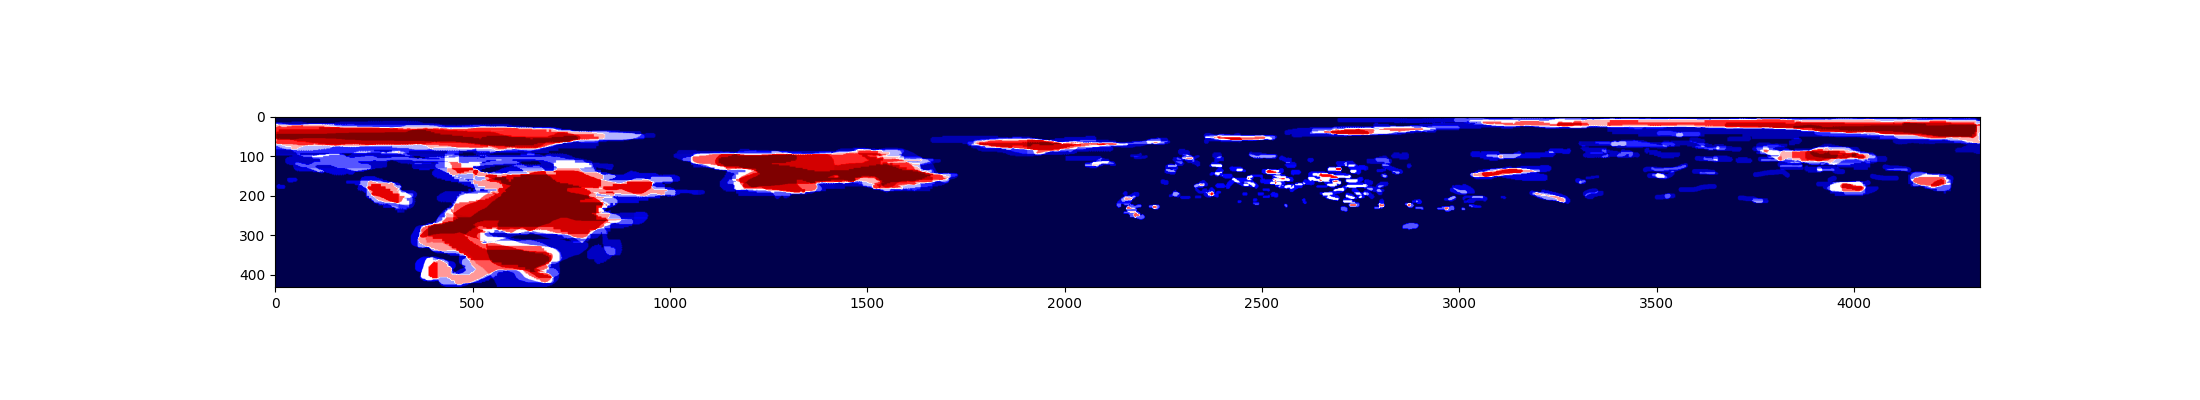

In [40]:
%matplotlib ipympl

#The highest resolution we have is 12. The final result we want is across all 
#longitude and from 90 to 55 latitude. Lat we can trust, Lon we cannot, the convention is inconsistent.
#Regardless, this means we need to set up arrays of size 4320 by 432. Huh, convenient that it's exactly
#A 1x10 scale. Fun.
#Do not add the extra 1, we are not wrapping around here.

landLakeLikelihood = [[0 for x in range(4320)] for x in range(432)] #Holds value
landLakeNum = [[0 for x in range(4320)] for x in range(432)] #Holds number of hits.
#To be eplicit, we will be storing this with X ranging from 0 to 360 degrees (noninclusive 360).
#And Y ranging from 90 to 54 (noninclusive 54). Index 0 is 90, yes, we go top down so it plots easily.

i=0
while (i < 9): #Go through each image. 
    x,y = 0,0
    #We need to find the latlon coordinates of the origin in this image.
    originY = (metadata[i][1] + 90)*12 
    #Lat is given negatively so we have to not only make it positive,
    #But also subtract off the value since for the image the north pole is index zero. 
    #If it ends up negative we are out of bounds! Fun.
    originX = (metadata[i][3] + 360)*12
    #Similar deal here, negative is out of bounds.
    #So when x,y = 0,0 we have our values.
    #And when originX,originY = 0,0 we are at the north pole. Actually just having y
    #be zero does this, but it's fine.

    #Some of our points use awkward lon conventions. Let's fix those.
    if (originX >= 4320):
        originX = -1000
        if (i == 0):
            originX = originX+75
    if (originX >= 1000):
        originX = originX - 360*12
        
    print(originX, originY)
    

    #Flyby Num, Up, Down, Left, Right, X Pixel Dimension, Y Pixel Dimension, Resolution

    while (y < len(allGrids[i])):
        x=0
        while (x < len(allGrids[i][0])):
            #For every pixel we need to add it to the same pixel in the main grid.
            #Use our origin points to find our index.
            newX = originX + x 
            newY = originY + y
            #print(x,y,originX,originY,newX,newY)
            if (newX >= 0 and newY >= 0 and newX < 4320 and newY < 432):
                #Basically, only if not out of bounds do we do anything.
                if (allGrids[i][y][x] == 1):
                    landLakeLikelihood[newY][newX] = landLakeLikelihood[newY][newX] - 1
                    landLakeNum[newY][newX] = landLakeNum[newY][newX] + 1
                if (allGrids[i][y][x] == 0):
                    landLakeLikelihood[newY][newX] = landLakeLikelihood[newY][newX] + 1
                    landLakeNum[newY][newX] = landLakeNum[newY][newX] + 1
                    #We'd like lake values to be positive.
                #If a value other than 0 or 1 is passed, do nothing. NOTHING! That's not a real pixel we need to skip it!
            x=x+1
        y=y+1
    i=i+1
plt.close()
fig, ax = plt.subplots(figsize = (22,4))
scaledMap = np.array(landLakeLikelihood)/np.array(landLakeNum)
image = ax.imshow(scaledMap, cmap = 'seismic', vmin=-1, vmax=1)


Now we have to lower the resolution to one pixel per degree, which means averaging out all this data. Which means we need to do some *averaging* onto a smaller grid!

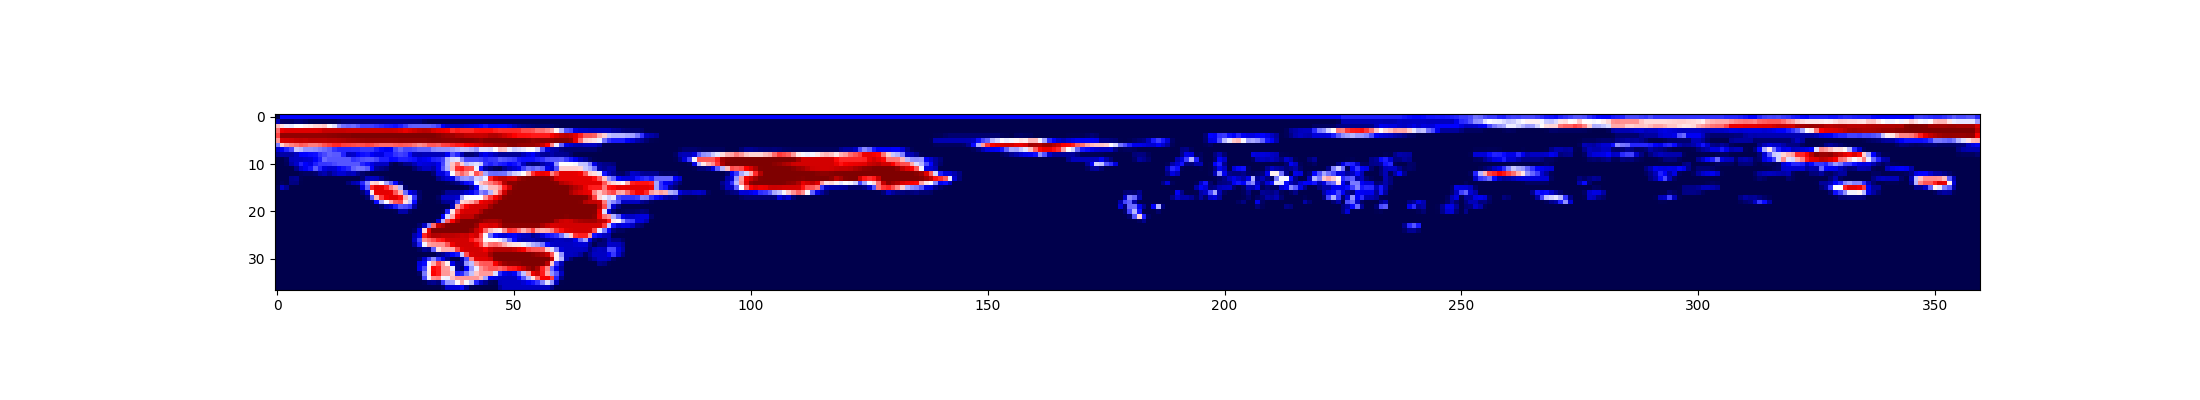

In [74]:
smallGrid = [[0 for x in range(360)] for x in range(37)] #Extra index in y for holding the bottom half-pixel due to lat not wrapping.
#We're downscaling by a factor of 12, every pixel will thus have 144 others to draw on, possibly excepting some of the edges.
#Edges: edges on lon cycle around to other side. Edges on lat do not. 

x,y = 0,0
while (x < 360):
    y=0
    while (y < 37):
        i,j = -6,-6 #Iterators start at -6, go to 5. "0" is the 12th pixel. 
        count = 0
        if (x == 0 and y == 0):
            #The corner piece! Must cycle to use points on the other side.
            i=0 #start in the middle.
            while (i < 6):
                j=-6
                while (j < 6):
                    if (j < 0):
                        count = count + scaledMap[y*12 + i][x*12 + j+4320]
                    else:
                        count = count + scaledMap[y*12 + i][x*12 + j]
                    j=j+1
                i=i+1
            smallGrid[y][x] = count/72.
        elif (x == 0 and y != 36):
            #Cycle to use points on other side.
            while (i < 6):
                j=-6
                while (j < 6):
                    if (j < 0):
                        count = count + scaledMap[y*12 + i][x*12 + j+4320]
                    else:
                        count = count + scaledMap[y*12 + i][x*12 + j]
                    j=j+1
                i=i+1
            smallGrid[y][x] = count/144.
        elif (y == 0):
            #Start partway through.
            i = 0
            while (i < 6):
                j=-6
                while (j < 6):
                    count = count + scaledMap[y*12 + i][x*12 + j]
                    j=j+1
                i=i+1
            smallGrid[y][x] = count/144.
        elif (y == 36):
            #STOP partway through.
            while (i < 0):
                j=-6
                while (j < 6):
                    count = count + scaledMap[y*12 + i][x*12 + j]
                    j=j+1
                i=i+1
            smallGrid[y][x] = count/72.
        else:
            while (i < 6):
                j=-6
                while (j < 6):
                    count = count + scaledMap[y*12 + i][x*12 + j]
                    j=j+1
                i=i+1
            smallGrid[y][x] = count/144.
        y=y+1
    x=x+1

plt.close()
fig, ax = plt.subplots(figsize = (22,4))
image = ax.imshow(smallGrid, cmap = 'seismic', vmin=-1, vmax=1)

Now we need to process this into what we desire: a mask that shows a "land" a "lake" and a "no go" zone for every pixel. The initial pass of this is as simple as setting the values to -1, 0, or 1 based on what they were previously.

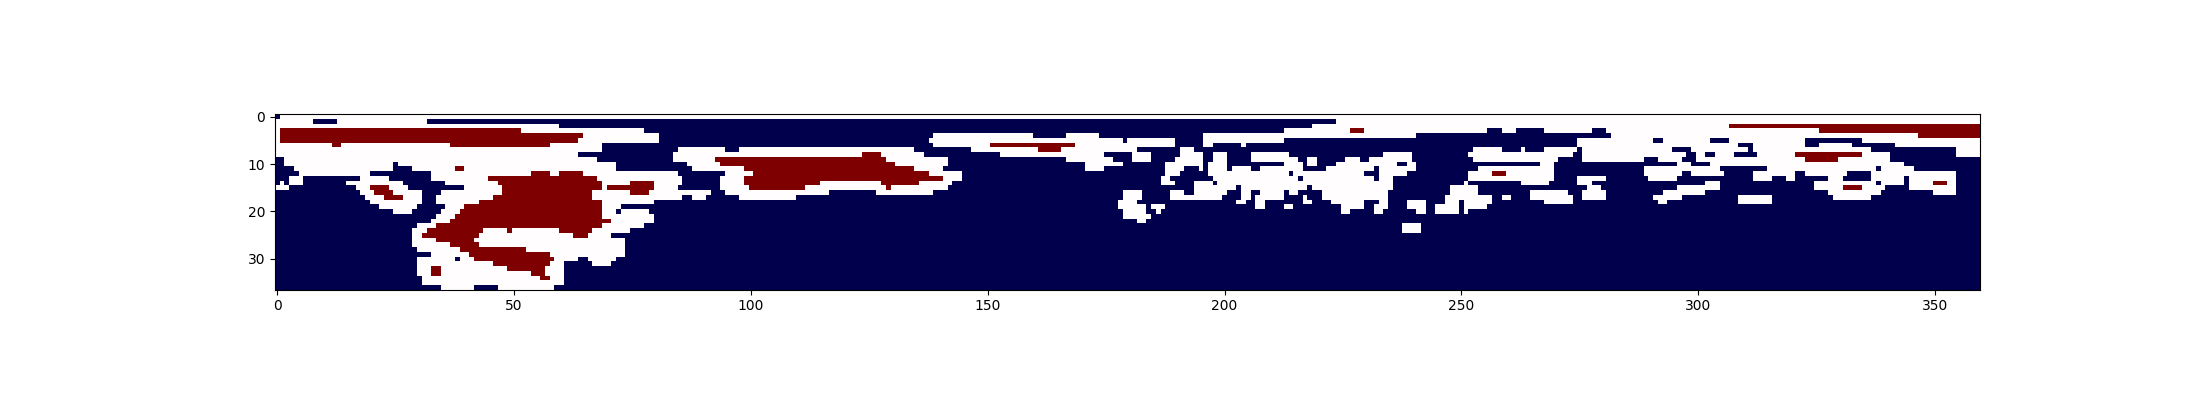

In [75]:
rigidMask = [[0 for x in range(360)] for x in range(37)] 

x,y = 0,0
while (x < 360):
    y=0
    while (y < 37):
        if(smallGrid[y][x] == -1):
            rigidMask[y][x] = -1
        elif(smallGrid[y][x] <=0.4):
            rigidMask[y][x] = 0
        else:
            rigidMask[y][x] = 1
        y=y+1
    x=x+1

plt.close()
fig, ax = plt.subplots(figsize = (22,4))
image = ax.imshow(rigidMask, cmap = 'seismic', vmin=-1, vmax=1)

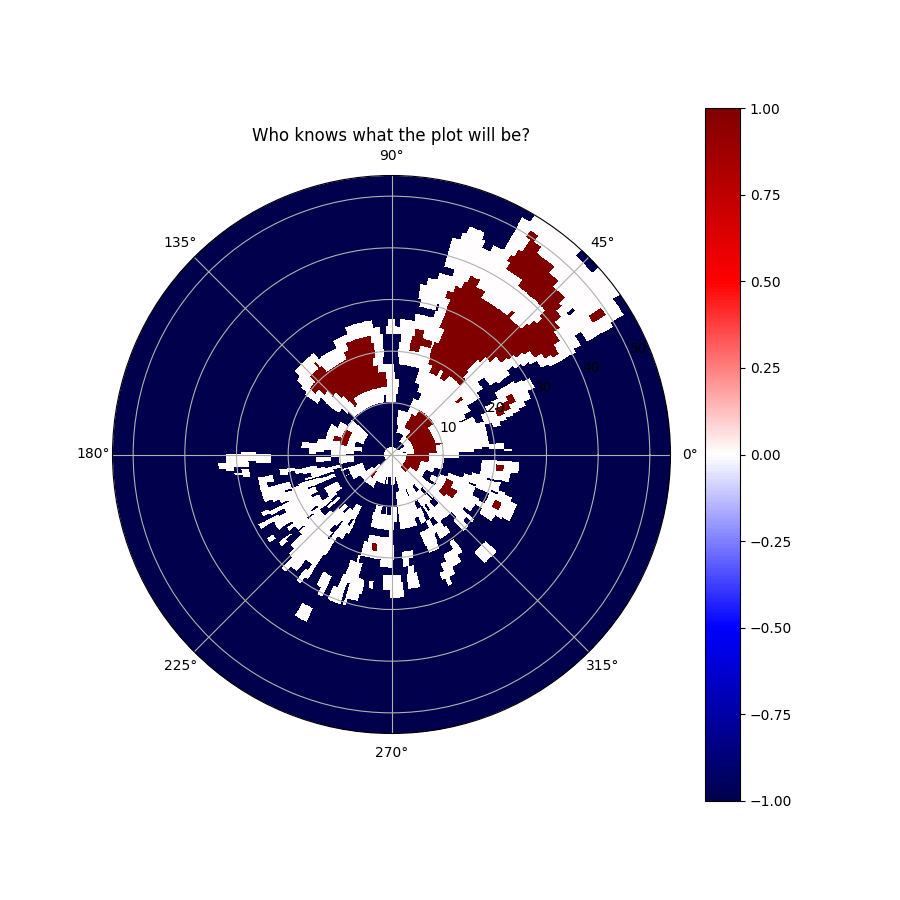

In [77]:
#RADIAL DISPLAY

#Display is in polar coordinates to give a good idea of what is actually going on.
#Polar assistance: https://stackoverflow.com/questions/73831636/pcolormesh-in-polar-coordinates-redux
fig, ax = plt.subplots(figsize = (9,9),subplot_kw=dict(projection='polar'))

#Now we do need to invert an axis.
#i=0
#while (i < len(compiledData)):
#    compiledData[i] = np.flip(compiledData[i])
#    i=i+1
#compiledData = np.flip(compiledData)

rhos2   = np.linspace(0.001,54,38) 
thetas2 = np.linspace(0,2.01*np.pi,361)
X,Y = np.meshgrid(thetas2,rhos2)

image = ax.pcolormesh(X,Y,rigidMask, cmap="seismic")
fig.colorbar(image,ax=ax)
ax.set(title = 'Who knows what the plot will be?') #Remove ticks.

plt.show()

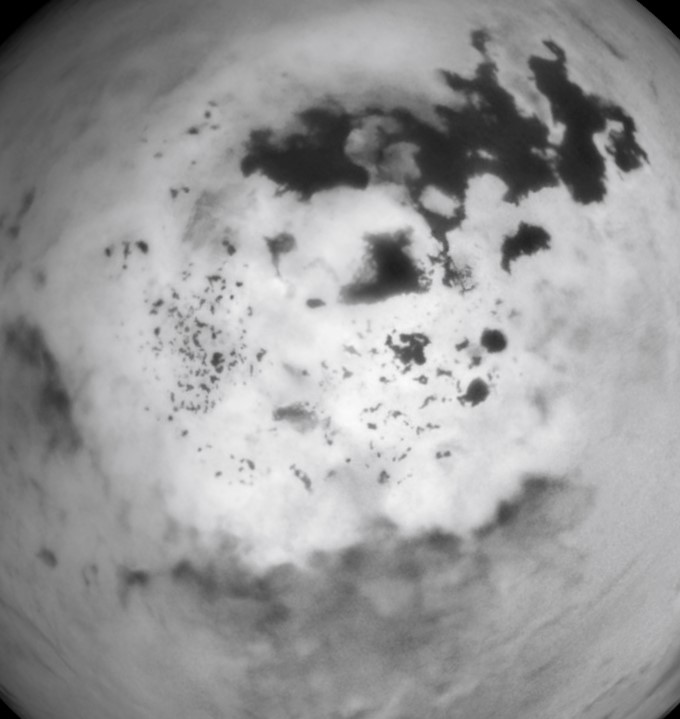

That's actually pretty good, it gets all the seas and the major lakes. Some poitns of contention are that large dark spot that might not even be a lake near the bottom, and the Throat of Kraken. 

However, these features are so small I doubt they'll affect much of anything considering all the data we're about to churn.

So, what next? Well, when we look at a pixel in real VIMS data we need to know how far away it is from a "no go" zone. If the distance is less than the real pixel's resolution, we can't use it. The question is what math do we need to use for this... How do we measure our resolution? 

The geofiles provide everything in km. So what we need to do is assign each part of the mask a "km" value of the closest "no go" zone. Let positive values be lakes, and negative be land--the actual distance is just the magnitude. 

In [88]:
#ALERT: CHECK THAT WE KNOW WHAT 0 LON IS!!!

distanceMask = [[0 for x in range(360)] for x in range(37)] 

x,y = 0,0
while (x < 360):
    y=0
    while (y < 37):
        if(rigidMask[y][x] != 0): #If it's already zero there's no need to change it.
            lat = 90 - y #Get real latitude.
            lon = x #x meanwhile correlates perfectly. ...We think, we should probably check that 0 lon is what we think 0 lon is...
            #Fortunately edges are hard divides so we don't have to make looping code, just "edge" code.
            #A smart way to do this would be to do an expansive algorithm. The dumb way to do it is to look at every pixel. The distance calculation isn't complicated, and we only have to do this once...
            #Slow and stupid but easy to code it is. Which means that for every pixel we look at... every pixel.
            dist = 10000 #larger than the radius of Titan, hehe. 
            X,Y = 0,0 #(x,y) for the second pixel. 
            while (X < 360):
                Y=0
                while (Y < 37):
                    if(rigidMask[Y][X] == 0): #Now we only care if a pixel IS zero!
                        LAT = 90 - Y #Get real latitude.
                        LON = X #x meanwhile correlates perfectly. ...We think, we should probably check that 0 lon is what we think 0 lon is...
                        print(lat,lon,LAT,LON)
                        newdist = 2*2575*math.asin(math.sqrt(math.sin((LAT-lat)/2.)*math.sin((LAT-lat)/2.)) + math.cos(lat)*math.cos(LAT)*math.sin((LON-lon)/2.)*math.sin((LON-lon)/2.))
                        if (newdist < dist):
                            dist = newdist
                    Y=Y+1
                X=X+1
            print(x,y,dist)
        y=y+1
    x=x+1

plt.close()
fig, ax = plt.subplots(figsize = (22,4))
image = ax.imshow(distanceMask, cmap = 'seismic', vmin=-1, vmax=1)

90 0 89 0
90 0 88 0
90 0 87 0
90 0 86 0
90 0 85 0
90 0 84 0
90 0 83 0
90 0 82 0
90 0 75 0
90 0 90 1
90 0 89 1
90 0 88 1
90 0 84 1
90 0 83 1
90 0 82 1
90 0 76 1
90 0 75 1
90 0 90 2
90 0 89 2
90 0 88 2
90 0 84 2
90 0 83 2
90 0 82 2
90 0 81 2
90 0 80 2
90 0 75 2
90 0 90 3
90 0 89 3
90 0 88 3
90 0 84 3
90 0 83 3
90 0 82 3
90 0 81 3
90 0 80 3


ValueError: math domain error

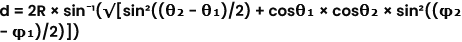

Below is the code to read in all the files and apply them to the mask.

In [84]:
#Imports
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
from scipy import ndimage

#First, read in the data into a matrix. 
cubeList = []
with open('selectedCubes.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        triplet = ["A","A","A"]
        triplet[0] = row[0]
        triplet[1] = row[1]
        triplet[2] = row[2]
        cubeList.append(triplet)
        line_count += 1

#Now, for every item in cubeList, we find the file it poitns to and read it in. 
#Then we examine those files for *something*. Whatever it is. 
#In this case we're seeking pixels to print out data from to a file.
#This time we're nuking noodles, so the test is simple and won't require iterations.
for item in cubeList:
    err = 0 #No error by default.
    
    #This code is copy adapted from the VIMS Cube Visualisation Interface Notebook. 
    #It is complicated.
    filepath = "C:\\Users\\deran\\Desktop\\CubeCSVDatabase\\" + item[1] + "\\" + item[0] + ".cub.csv"

    #Now we extract the axes file as well...
    cubeAxesfp = filepath.removesuffix(".csv") + ".axes.csv"
    
    #And you know what why not all the others as well.
    cubeGeofpIR = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
    cubeGeofpIRaxes = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"
    #Basically, we don't use axesfp if it's not needed.
    
    #Skeleton code nabbed from https://realpython.com/python-csv/
    #We need to be able to handle both local and other cubes. 
    #Pyvims can help us, but as I don't want to redo all the code we'll find a way to store
    #it in the way the code understands.
    
    #Step 1: use the axes to determine the size of what we're dealing with.
    xAxisCube = []
    yAxisCube = []
    zAxisCube = []
    
    xAxisGeoIR = []
    yAxisGeoIR = []
    zAxisGeoIR = []

    try:
        with open(cubeAxesfp) as csv_file: #remember to tab.
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    i = 0
                    L = len(row)
                    while (i < L-1):
                        if (line_count == 0):
                            xAxisCube.append(row[i])
                        elif (line_count == 1):
                            yAxisCube.append(row[i])
                        elif (line_count == 2):
                            zAxisCube.append(row[i])
                        i = i+1
                    line_count += 1
    except:
        print("No Cube Axes", item[0], item[1])
        err = 1 #whoops.        
    try:
        with open(cubeGeofpIRaxes) as csv_file: #remember to tab.
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    i = 0
                    L = len(row)
                    while (i < L-1):
                        if (line_count == 0):
                            xAxisGeoIR.append(row[i])
                        elif (line_count == 1):
                            yAxisGeoIR.append(row[i])
                        elif (line_count == 2):
                            zAxisGeoIR.append(row[i])
                        i = i+1
                    line_count += 1
    except:
        print("No Geo Axes", item[0], item[1])
        err = 1 #whoops.
        
    #We now have an x, y, and z axis. x and y axes are just ordinal, but the z axis contains wavelength in microns.
    #The lengths of these arrays tell us how to extract the data.
    
    cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
    geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]
    
    #The above holds the data of the cube itself. 
    try:
        with open(filepath) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            i, j, k = 0, 0, 0
            for row in csv_reader:
                while (i < len(xAxisCube)):
                    cubeData[i][j][k] = float(row[i])
                    if (math.isnan(cubeData[i][j][k])):
                        cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                    elif (cubeData[i][j][k] < 0):
                        cubeData[i][j][k] = 0 #Negative values are nonsense.
                    elif (cubeData[i][j][k] > 1):
                        cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                    i = i + 1
                i = 0
                j = j + 1
                if (j >= len(yAxisCube)):
                    j = 0
                    k = k + 1
                line_count += 1
    except:
        print("No Cube File (how?)", item[0], item[1])
        err = 1 #whoops.
    try:
        with open(cubeGeofpIR) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            i, j, k = 0, 0, 0
            for row in csv_reader:
                while (i < len(xAxisGeoIR)):
                    geoIRData[i][j][k] = float(row[i])
                    if (math.isnan(geoIRData[i][j][k])):
                        geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                    elif (geoIRData[i][j][k] < -1000):
                        geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                    i = i + 1
                i = 0
                j = j + 1
                if (j >= len(yAxisGeoIR)):
                    j = 0
                    k = k + 1
                line_count += 1
    except:
        print("No Geo File", item[0], item[1])
        err = 1 #Whoops.
    #The data is now read in.

    #BOOKKEEPING: declare where the windows are. 
    windowum = [0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576]
    windowInd = [80, 108, 120, 139, 165, 206, 212, 344]
    windowIndAlt = [3,12,24,43,69,110,116,248]
    if (len(zAxisCube) <= 256):
        windowInd = windowIndAlt

    print("Working", item[0], item[1])
        
    #Now we can do stuff with it. In this case, we need to examine every pixel and print out the "viable" ones to a file.
    if (err == 0):
        with open("pixelResults.csv", 'a') as dataEntry:  
            x,y = 0,0 
            while (x < len(xAxisCube)):
                y = 0
                while (y < len(yAxisCube)):
                    if (geoIRData[x][y][0] >= 55.0): #Only look at pixels that are at the northern pole. 
                        maskTest = False
                        classification = "N" #No class, only switches if we get a pixel we like.
                        
                        if (maskTest == True): #Do not bother with anything the mask hates.
                            temp = np.transpose(cubeData)
                            outfile = item[0] + "," #Cube number.
                            outfile = outfile + item[1] + "," #Flyby number
                            outfile = outfile + item[2] + "," #Resolution classification 
                            outfile = outfile + classification + "," #Land or Lake. 
                            outfile = outfile + str(x) + "," + str(y) + "," #Pixel Coordinates
                            outfile = outfile + str(geoIRData[x][y][0]) + "," + str(geoIRData[x][y][1]) + "," #Latlon
                            inci = geoIRData[x][y][5]
                            emis = geoIRData[x][y][6]
                            azim = 0.
                            #Azimuth formula from Jason Barnes' phasecurve.c++
                            p = geoIRData[x][y][4] #used to calculate azimuth.
                            ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
                            azim = np.arccos(ratio)
                            #Of course, this might be nan-ing. All the nans need their own values.
                            if((math.isnan(azim) == True) and (ratio>0.)):
                                azim = 0.
                            elif((math.isnan(azim) == True) and (ratio<0.)):
                                azim = 0.
                            elif((inci==0) and (emis==0)):
                                azim = 0.
                            elif(math.isnan(azim) == True):
                                print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
                            if (inci < 0):
                                inci = 0
                            elif (inci > 100):
                                inci = 100
                            if (emis < 0):
                                emis = 0
                            elif (emis > 90):
                                emis = 90
                            if (azim < 0):
                                azim = 0
                            if (azim > 180):
                                azim = 180
                            outfile = outfile + str(inci) + "," + str(emis) + "," #inci emis
                            outfile = outfile + str(math.degrees(azim)) + "," #azimuth
                            outfile = outfile + str(geoIRData[x][y][2]) + "," + str(geoIRData[x][y][4]) + "," #res phase
                            #Now we need the window wavelengths, which means we need to *read* the data itself.
                            outfile = outfile + str(np.transpose(temp[windowInd[0]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[1]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[2]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[3]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[4]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[5]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[6]])[x][y]) + "," 
                            outfile = outfile + str(np.transpose(temp[windowInd[7]])[x][y]) + "," + "\n"        
                            #print(outfile)
                            dataEntry.write(outfile)
                    y=y+1
                x=x+1
    


Working CM_1477467367_1 Ta
Working CM_1477473027_6 Ta
Working CM_1477473988_1 Ta
Working CM_1477474917_1 Ta
Working CM_1481599708_1 Tb
Working CM_1481611895_1 Tb
Working CM_1481612621_1 Tb
Working CM_1481614387_1 Tb
Working CM_1487117013_1 T3


C:\Users\deran\AppData\Local\Temp\ipykernel_18668\2653620069.py:179: RuntimeWarning: invalid value encountered in arccos
  azim = np.arccos(ratio)


Working CM_1490961829_2 T4
Working CM_1490967391_2 T4
Working CM_1490967585_1 T4
Working CM_1491002149_1 T4
Working CM_1491009137_1 T4
Working CM_1491009733_1 T4
Working CM_1491009935_1 T4
Working CM_1491010336_1 T4
Working CM_1492336501_1 T5
Working CM_1492339372_1 T5
Working CM_1492340963_1 T5
Working CM_1492342411_1 T5
No Cube File (how?) CM_1492344366_1 T5
Working CM_1492344366_1 T5
No Cube File (how?) CM_1492345550_1 T5
Working CM_1492345550_1 T5
Working CM_1492346729_1 T5


KeyboardInterrupt: 